In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from discopy.grammar import Word
from discopy.rigid import Cup, Id, Ty
import torch
import random
from sentence_transformers import SentenceTransformer
from lambeq import LossFunction, PennyLaneModel, PytorchTrainer, QuantumTrainer, SPSAOptimizer, NumpyModel, MSELoss, Dataset, AtomicType, IQPAnsatz, Sim14Ansatz, Sim15Ansatz, StronglyEntanglingAnsatz, BobcatParser
from lambeq.pregroups import remove_cups
import jax as jnp
from jax import numpy as jnp
import os
import pickle


EPOCHS = 100
SEED = 42
BATCH_SIZE = 2
NOUN_QUBIT_COUNT = 1
SENTENCE_QUBIT_COUNT = 1
OPTIMIZER_PARAM = {'a': 0.75, 'c': 0.1, 'A':0.01*EPOCHS}

In [3]:
def read_and_preprocess_data():
    df = pd.read_csv('Data/LargerSadrKartTransative.txt', sep=' ')
    # assign column names to the dataframe
    df.columns = ['annotator', 'subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2', 'score']
    # group the data by the three sentence columns and calculate the mean and standard deviation of the score column
    grouped_data = df.groupby(['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']).agg({'score': [np.mean, np.std]}).reset_index()
    # flatten the multi-level column names of the grouped data
    grouped_data.columns = [' '.join(col).strip() for col in grouped_data.columns.values]
    # rename the mean and std columns to 'score' and 'range' respectively
    grouped_data.rename(columns={'score mean': 'score', 'score std': 'range'}, inplace=True)
    grouped_data['score'] = grouped_data['score']/grouped_data['score'].max()
    unique_word_list = []
    for ind, row in grouped_data.iterrows():
        for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
            unique_word_list.append(i)
    unique_word_list = list(set(unique_word_list)) #Makes word_list from word_list's unique elements
    grouped_data.to_csv("Data/AveragedLargerSadrKartTransative.txt")
    # Create an instance of MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    # Rescale the 'score' column
    grouped_data['score'] = scaler.fit_transform(grouped_data[['score']])
    return grouped_data, unique_word_list
dataset, unique_word_list = read_and_preprocess_data()

In [4]:
def DimReduceByPCA(input_array, new_dims):
	pca = PCA(n_components = new_dims)
	pca.fit(input_array)
	data_pca = pca.transform(input_array)
	return data_pca

def dimensionality_reduction(embedder, unique_word_list):
    #Making a dict of words as keys do our dimensionality vectors: {word: {dim_method : vector}}
    corpus_array = np.zeros(shape=(len(unique_word_list), 384))
    word_vector_dict = {}
    for i, word in enumerate(unique_word_list):
            vector = embedder.encode(word)
            word_vector_dict.update({word: {len(vector):vector}})
            corpus_array[i] = vector
            
    for j in range(12):
        pca_dim = j
        pca = DimReduceByPCA(corpus_array, pca_dim)
        for i, word in enumerate(unique_word_list):
                word_vector_dict[word].update({"pca_"+str(pca_dim):pca[i]})
    return word_vector_dict

embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
word_vector_dict = dimensionality_reduction(embedder, unique_word_list)

In [5]:
def retrive_nth_rows_sentences(data, row1, row2=None):
    if not row2:
        row2=row1
    sentence1 = data['subject'+str(1)][row1] + " " + data['verb'+str(1)][row1]  + " " + data['object'+str(1)][row1] 
    sentence2 = data['subject'+str(2)][row2] + " " + data['verb'+str(2)][row2]  + " " + data['object'+str(2)][row2] 
    return sentence1, sentence2

def make_sentence_a_state(sentence):
    diagram = diagram_to_sentence(sentence.split(" "))
    diagram = remove_cups(diagram)
    return diagram

def make_diagram_a_circuit(diagram, ansatz, dagger=False):
    discopy_circuit = ansatz(diagram)
    if dagger:
        discopy_circuit = discopy_circuit.dagger()
    return discopy_circuit

def concat_circuits_into_inner_product(circuit1, circuit2):
    concat_circuit = circuit1 >> circuit2
    return concat_circuit

def make_diagrams(data, sentence1, sentence2=None):
    if type(sentence1) == int:
        sentence1, sentence2 = retrive_nth_rows_sentences(data, sentence1, sentence2)
    diagram1 = make_sentence_a_state(sentence1)
    diagram2 = make_sentence_a_state(sentence2)
    return diagram1, diagram2

def diagram_to_sentence(word_list):
    n, s = Ty('n'), Ty('s')
    words = [
        Word(word_list[0], n),
        Word(word_list[1], n.r @ s @ n.l),
        Word(word_list[2], n)
    ]
    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
    assert Id().tensor(*words) == words[0] @ words[1] @ words[2]
    assert Ty().tensor(*[n.r, s, n.l]) == n.r @ s @ n.l
    diagram = Id().tensor(*words) >> cups
    return diagram

def plot_model_over_training(trainer):
    """
    Plots the training of a model in two graphs:
        - Traing Loss vs validation Loss, colour is epoch
        - Two Losses against epochs. 
    """
    epoch_count = range(trainer.epochs)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.figsize=(20,10)

    ax1.scatter(trainer.val_costs,trainer.train_epoch_costs,c=epoch_count, cmap='gray')
    ax1.set_xlabel("Validation Loss")
    ax1.set_ylabel("Training Loss")
    ax1.set_title("Loss of Validation and Training, should be a nice curve")

    ax2.set_title("Train & Val Losses")
    ax2.plot(epoch_count, trainer.val_costs, label = 'Validate')
    ax2.plot(epoch_count, trainer.train_epoch_costs, label = 'Train')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    fig.show()

def retrive_word_param_from_symbols(word_symbol, noun_parameters, subject_parameters):
    word = word_symbol.name.split("_")
    word_string = word[0]
    word_type = word[-2]
    if word_type == "n":
        word_dims = get_word_dims_from_ansatz(ANSATZ)[0]
    elif "@" in word_type:
        word_dims = get_word_dims_from_ansatz(ANSATZ)[1] 
    word_index = int(word[-1])
    return word_string, word_dims, word_index

def get_word_dims_from_ansatz(ANSATZ):
    noun = ANSATZ.ob_map[Ty('n')]
    sent = ANSATZ.ob_map[Ty('s')]
    if isinstance(ANSATZ, IQPAnsatz):
        noun_parameters = 3 if noun == 1 else (noun-1)
        subject_parameters = noun + noun + sent - 1
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, Sim14Ansatz):
        noun_parameters = 3 if noun == 1 else noun*4
        subject_parameters = 4*(noun + noun + sent)
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, Sim15Ansatz):
        noun_parameters = 3 if noun == 1 else noun*2
        subject_parameters = 2*(noun + noun + sent)
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, StronglyEntanglingAnsatz):
        print("ERROR NOT IMPLEMENTED YET")
        pass

def pca_to_rotations(symbols):
    noun_parameters, subject_parameters = get_word_dims_from_ansatz(ANSATZ)

    weights = np.zeros(shape=(len(symbols)))
    for i, word_symbol in enumerate(symbols):
        word_string, word_dims, word_index = retrive_word_param_from_symbols(word_symbol, noun_parameters, subject_parameters)
        weights[i] = word_vector_dict[word_string]['pca_'+str(word_dims)][word_index]/(2*np.pi)
    return weights

def normal_distribution_to_rotations(symbols):
    noun_parameters, subject_parameters = get_word_dims_from_ansatz(ANSATZ)

    weights = np.zeros(shape=(len(symbols)))
    for i, word_symbol in enumerate(symbols):
        word_string, word_dims, word_index = retrive_word_param_from_symbols(word_symbol, noun_parameters, subject_parameters)
        
        mean_of_word = word_vector_dict[word_string][384].mean()
        std_of_word = word_vector_dict[word_string][384].std()
        s = np.random.normal(mean_of_word, std_of_word, 1)

        weights[i] = s
    return weights

def make_circuit_from_diagrams(diagram1, diagram2, ansatz, drawing=False):
    discopy_circuit1 = make_diagram_a_circuit(diagram1, ansatz)
    discopy_circuit2 = make_diagram_a_circuit(diagram2, ansatz, dagger=True)
    discopy_circuit = concat_circuits_into_inner_product(discopy_circuit1, discopy_circuit2)

    if drawing:
        discopy_circuit1.draw(figsize=(5, 5))
        discopy_circuit2.draw(figsize=(5, 5))
        discopy_circuit.draw(figsize=(5, 10))   

    pennylane_circuit = discopy_circuit.to_pennylane()
    return pennylane_circuit, discopy_circuit

def make_circuit_from_df_row(data, row_number, ansatz):
    diagram1, diagram2 = make_diagrams(data, row_number)
    qml_circuit, discopy_circuit = make_circuit_from_diagrams(diagram1, diagram2, ansatz, False)
    return qml_circuit, discopy_circuit

In [15]:
def get_datasets(ansatz):
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    labels = dataset['score']

    training = pd.read_csv("Data/TrainingData.txt")
    test = pd.read_csv("Data/TestData.txt")

    train_data =  [make_circuit_from_df_row(training, i, ansatz)[1] for i in range(len(training))]
    train_labels = labels[training['Unnamed: 0'].values]
    val_data = [make_circuit_from_df_row(test, i, ansatz)[1] for i in range(len(test))] 
    val_labels = labels[test['Unnamed: 0'].values]

    diagrams = train_data + val_data

    train_dataset = Dataset(train_data,train_labels,batch_size=BATCH_SIZE)
    val_dataset = Dataset(val_data, val_labels, batch_size=BATCH_SIZE)
    return diagrams, train_dataset, val_dataset

In [16]:
class EncodedNumpyModel(NumpyModel):
     def initialise_weights(self) -> None:
        if not self.symbols:
            raise ValueError('Symbols not initialised. Instantiate through '
                            '`from_diagrams()`.')
        self.weights = self.param_initialise_method(self.symbols)

class MeanAbsoluteErrorLoss(LossFunction):
    def calculate_loss(self,
                       y_pred: np.ndarray | jnp.ndarray,
                       y_true: np.ndarray | jnp.ndarray) -> float:
        self._match_shapes(y_pred, y_true)

        return float(self.backend.mean(self.backend.abs(y_pred - y_true)))


class HuberLoss(LossFunction):
    def __init__(self,
                 use_jax: bool = False,
                 epsilon: float = 1e-9,
                 delta: float = 1.0) -> None:
        self._delta = delta
        super().__init__(use_jax, epsilon)

    def calculate_loss(self,
                       y_pred: np.ndarray | jnp.ndarray,
                       y_true: np.ndarray | jnp.ndarray) -> float:

        self._match_shapes(y_pred, y_true)

        absolute_error = self.backend.abs(y_pred - y_true)
        quadratic_loss = 0.5 * self.backend.square(absolute_error)
        linear_loss = self._delta * (absolute_error - 0.5 * self._delta)
        loss_val: float = float(self.backend.mean(
            self.backend.where(absolute_error < self._delta, quadratic_loss, linear_loss)
        ))
        return loss_val

In [17]:
import os
import joblib

import os
import numpy as np

def save_model_data(model_data, model_filepath):
    with open(model_filepath, 'wb') as model_file:
        joblib.dump(model_data, model_file)

def load_model_data(model_filepath):
    with open(model_filepath, 'rb') as model_file:
        model_data = joblib.load(model_file)
    return model_data

def run_quantum_trainer(model_type, ansatz, loss_function, optimizer, optim_hyperparams, num_epochs, batch_size, seed, text='text'):
    diagrams, train_dataset, val_dataset = get_datasets(ansatz)

    noun_count = ansatz.ob_map[Ty('n')]
    sentence_count = ansatz.ob_map[Ty('s')]
    
    ansatz_name = ansatz.__class__.__name__.lower()
    loss_name = loss_function.__class__.__name__.lower()
    optimizer_name = optimizer.__name__.lower()
    optimizer_hyperparams_str = '_'.join([f"{key}{val}" for key, val in optim_hyperparams.items()])

    model_folder = f"{model_type}_{noun_count}_{sentence_count}_{ansatz_name}_{loss_name}_{optimizer_name}_{optimizer_hyperparams_str}_epochs{num_epochs}_batch{batch_size}_seed{seed}"
    model_folder_path = os.path.join("models", model_folder)

    if os.path.exists(model_folder_path):
        # If the model folder already exists, load the information from the files and return
        model_params_filepath = os.path.join(model_folder_path, "model_params.joblib")
        training_losses_filepath = os.path.join(model_folder_path, "training_losses.npy")
        validation_losses_filepath = os.path.join(model_folder_path, "validation_losses.npy")

        model_params = joblib.load(model_params_filepath)
        training_losses = np.load(training_losses_filepath)
        validation_losses = np.load(validation_losses_filepath)

        return model_params, training_losses, validation_losses

    # Initialize the model and trainer based on the provided ansatz
    if model_type == 'random':
        model = NumpyModel.from_diagrams(diagrams, use_jit=True)
    elif model_type == 'pca':
        model = EncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
        model.type_of_encoding = 'pca'
        model.param_initialise_method = pca_to_rotations
        model.initialise_weights()
    elif model_type == 'normal':
        model = EncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
        model.param_initialise_method = normal_distribution_to_rotations
        model.initialise_weights()
    else:
        raise ValueError(f"Invalid ansatz: {ansatz_name}")

    trainer = QuantumTrainer(
        model,
        loss_function=loss_function,
        epochs=num_epochs,
        optimizer=optimizer,
        optim_hyperparams=optim_hyperparams,
        evaluate_on_train=True,
        verbose=text,
        seed=seed
    )
    trainer.fit(train_dataset, val_dataset, logging_step=10)
    
    model_params = model.weights
    training_losses = trainer.train_epoch_costs
    validation_losses = trainer.val_costs

    os.makedirs(model_folder_path, exist_ok=True)

    model_params_filepath = os.path.join(model_folder_path, "model_params.joblib")
    training_losses_filepath = os.path.join(model_folder_path, "training_losses.npy")
    validation_losses_filepath = os.path.join(model_folder_path, "validation_losses.npy")

    joblib.dump(model_params, model_params_filepath)
    np.save(training_losses_filepath, training_losses)
    np.save(validation_losses_filepath, validation_losses)

    return model_params, training_losses, validation_losses

In [21]:
ansatz_param_config = {
    #'1_1':{AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
    '2_1':{AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
    #'3_3':{AtomicType.NOUN: 3, AtomicType.SENTENCE: 3},
    #'4_1':{AtomicType.NOUN: 4, AtomicType.SENTENCE: 1},
}

optimizer_param_config = {
       '0.1_0.01_'+str(0.01*EPOCHS): {'a': 0.075, 'c': 0.001, 'A':0.01*EPOCHS},
       #'4_2_'+str(0.01*EPOCHS): {'a': 4, 'c': 2, 'A':0.01*EPOCHS}
}

ansatz_config = {
        'IQP': IQPAnsatz,
        #'Sim14': Sim14Ansatz,
        #'Sim15': Sim15Ansatz,
    }

loss_function_config = {
        'mse': MSELoss(),
        #'mae' :MeanAbsoluteErrorLoss(),
        #'huber':HuberLoss(),
    }

optimizer_config = {
        'spsa': SPSAOptimizer,
    }

for ansatz_name, ansatz in ansatz_config.items():
    for ansatz_param_name, ansatz_param in ansatz_param_config.items():
        for loss_name, loss_function in loss_function_config.items():
            for optimizer_name, optimizer in optimizer_config.items():
                for o_param_name, o_param in optimizer_param_config.items():
                    print(ansatz_name, ansatz_param_name, loss_name, optimizer_name, EPOCHS, BATCH_SIZE, SEED)
                    run_quantum_trainer('random', ansatz(ansatz_param, n_layers = 1), loss_function, optimizer, o_param, EPOCHS, BATCH_SIZE, SEED, "text")

IQP 2_1 mse spsa 100 2 42


Epoch 1:    train/loss: 0.5328   valid/loss: 0.5850
Epoch 10:   train/loss: 0.5328   valid/loss: 0.5850
Epoch 20:   train/loss: 0.5328   valid/loss: 0.5850
Epoch 30:   train/loss: 0.5328   valid/loss: 0.5850
Epoch 40:   train/loss: 0.5328   valid/loss: 0.5850
Epoch 50:   train/loss: 0.5328   valid/loss: 0.5850
Epoch 60:   train/loss: 0.5327   valid/loss: 0.5850
Epoch 70:   train/loss: 0.5327   valid/loss: 0.5850
Epoch 80:   train/loss: 0.5327   valid/loss: 0.5850
Epoch 90:   train/loss: 0.5327   valid/loss: 0.5850
Epoch 100:  train/loss: 0.5327   valid/loss: 0.5850

Training completed!


In [14]:
diagrams, train_dataset, val_dataset = get_datasets(IQPAnsatz({AtomicType.NOUN: 4, AtomicType.SENTENCE: 4}, n_layers=1))

In [24]:
train_dataset.targets

0     -0.176357
2     -0.949444
4     -0.160207
5     -0.953488
8     -0.443883
         ...   
99    -0.342770
101   -0.984496
103   -0.951550
105   -0.844961
106   -0.577167
Name: score, Length: 74, dtype: float64

In [26]:
train_dataset.data[0].free_symbols

{agent__n_0,
 agent__n_1,
 agent__n_2,
 buy__n.r@s@n.l_0,
 buy__n.r@s@n.l_1,
 buy__n.r@s@n.l_10,
 buy__n.r@s@n.l_2,
 buy__n.r@s@n.l_3,
 buy__n.r@s@n.l_4,
 buy__n.r@s@n.l_5,
 buy__n.r@s@n.l_6,
 buy__n.r@s@n.l_7,
 buy__n.r@s@n.l_8,
 buy__n.r@s@n.l_9,
 family__n_0,
 family__n_1,
 family__n_2,
 home__n_0,
 home__n_1,
 home__n_2,
 property__n_0,
 property__n_1,
 property__n_2,
 sell__n.r@s@n.l_0,
 sell__n.r@s@n.l_1,
 sell__n.r@s@n.l_10,
 sell__n.r@s@n.l_2,
 sell__n.r@s@n.l_3,
 sell__n.r@s@n.l_4,
 sell__n.r@s@n.l_5,
 sell__n.r@s@n.l_6,
 sell__n.r@s@n.l_7,
 sell__n.r@s@n.l_8,
 sell__n.r@s@n.l_9}

C:\Users\henry\AppData\Local\Temp\ipykernel_76240\1789708127.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(ansatz_config))
C:\Users\henry\AppData\Local\Temp\ipykernel_76240\1789708127.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(val_costs, train_costs, c=color, cmap='Oranges_r', label=label)
C:\Users\henry\AppData\Local\Temp\ipykernel_76240\1789708127.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val_costs, trai

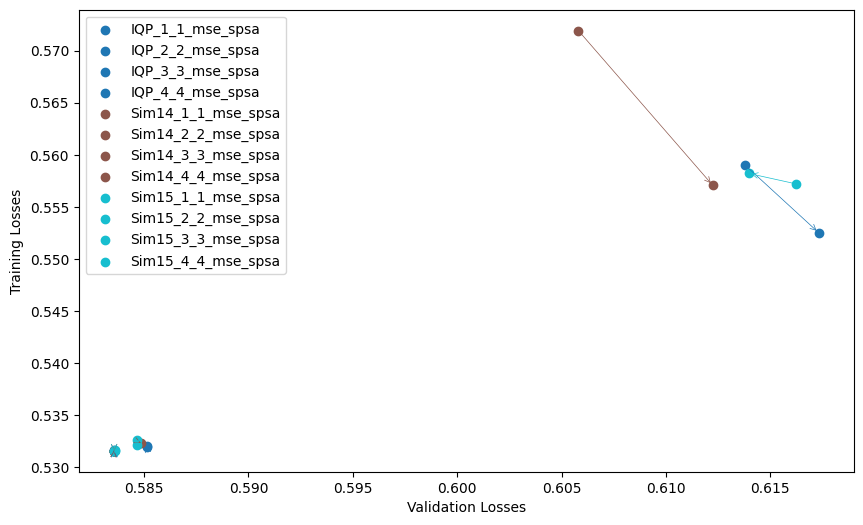

In [ ]:
import os
import joblib
import matplotlib.pyplot as plt
import numpy as np

# ... (same code to define ansatz_config, ansatz_param_config, loss_function_config, optimizer_config, and other variables)

# Create an empty list to store data for each model
data_list = []

# Loop over all combinations of model configurations
for ansatz_name, ansatz in ansatz_config.items():
    for ansatz_param_name, ansatz_param in ansatz_param_config.items():
        for loss_name, loss_function in loss_function_config.items():
            for optimizer_name, optimizer in optimizer_config.items():
                model_type = 'random'  # You can change this based on your actual model types
                model_params, training_losses, validation_losses = run_quantum_trainer(model_type, ansatz(ansatz_param, n_layers=1), loss_function, optimizer, EPOCHS, BATCH_SIZE, SEED, "text")

                # Store the data for each model in a tuple
                data_list.append((validation_losses, training_losses, f"{ansatz_name}_{ansatz_param_name}_{loss_name}_{optimizer_name}"))

# Plotting the scatter plot with arrows connecting the points
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap with different shades for each ansatz type
cmap = plt.cm.get_cmap('tab10', len(ansatz_config))

# Create a dictionary to store the color mapping for each ansatz type
ansatz_color_map = {}

# Plot each model's training and validation losses with arrows connecting the points
for i, (val_costs, train_costs, label) in enumerate(data_list):
    # Get the ansatz name from the label
    ansatz_name = label.split('_')[0]

    # If the ansatz is not already in the color map, add it with a new shade
    if ansatz_name not in ansatz_color_map:
        ansatz_color_map[ansatz_name] = cmap(len(ansatz_color_map))

    # Get the color for the current ansatz
    color = ansatz_color_map[ansatz_name]

    # Plot the validation losses with arrows connecting the points
    for j in range(len(val_costs) - 1):
        ax.annotate("", xy=(val_costs[j + 1], train_costs[j + 1]), xytext=(val_costs[j], train_costs[j]),
                    arrowprops=dict(arrowstyle="->", color=color, lw=0.5))

# Plot the scatter plot for each model
for i, (val_costs, train_costs, label) in enumerate(data_list):
    # Get the ansatz name from the label
    ansatz_name = label.split('_')[0]

    # Get the color for the current ansatz
    color = ansatz_color_map[ansatz_name]

    ax.scatter(val_costs, train_costs, c=color, cmap='Oranges_r', label=label)

# Add labels and legend
ax.set_xlabel('Validation Losses')
ax.set_ylabel('Training Losses')
ax.legend()
plt.show()

In [17]:
train_costs, val_costs

([0.531587531211207, 0.5315858739478564],
 [0.5835603379151401, 0.583560336381197])